# Session 1
## Explorative Analysis of EPEXPOT Prices

The first step in the data mining process is to develop an understanding of the business as well as the data that is needed to support it (see CRISP-DM). The next step in the process is data preparation, wich requires is to first akquire the data. Nowadays plenty of data is available on the web, either through APIs (Twitter, Goolgle, Quandl, etc.) or on the web pages themselves. If data is somehow embedded on a website, we need to go through a process called scraping, in order to separate the required data from the rest of the content. 

### Scraping EPEXSPOT Prices

Let us assume that we need hourly electricity prices from the EPEXSPOT market for our business case. EPEXSPOT sells this data, but it must also provide the data on its website, for example, data for the [current week](https://www.epexspot.com/en/market-data/dayaheadauction/auction-table). 

#### BeautifulSoup

To akquire the content and weed out the needed prices, we are going to use a Python library called [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/).

In [1]:
#!pip install bs4 requests lxml

In [2]:
from bs4 import BeautifulSoup
import urllib.request

If we provide the day of the week in the ULR, we get one week of hourly prices, with the given date as the last day of the week. We can use this in a later step to build a fully automated mining bot. By providing BeautifulSoup with the content of the url, it can import and store the content in a proprietary format.

In [3]:
date = '2017-10-11'
url = urllib.request.urlopen('https://www.epexspot.com/en/market-data/dayaheadauction/auction-table/%s/de'%date)
url = url.read()
soup = BeautifulSoup(url,"lxml")

All price data is available in a table with a *table* tag and has *list hours responsive* as its class name. We can therefore tell BeautifulSoup to extract content that meets this specification from the website and store it for us. BeautifulSoup stores all content that meets this requirement as a *ResultSet* and the individual elements in the set as *Tag*.

In [4]:
table = soup.find_all('table', class_='list hours responsive')
#finds an element with class 'list hours responsive' and names it 'table' and creates a ResultSet
print(type(table), type(table[1]))
#what we get is a ResultSet and the elements of that ResultSet are Tags

<class 'bs4.element.ResultSet'> <class 'bs4.element.Tag'>


In [5]:
soup.find_all?

#
Extracts a list of Tag objects that match the given
criteria.  You can specify the name of the Tag and any
attributes you want the Tag to have.
The value of a key-value pair in the 'attrs' map can be a
string, a list of strings, a regular expression object, or a
callable that takes a string and returns whether or not the
string matches for some custom definition of 'matches'. The
same is true of the tag name.
#

The result set contains three tables, each holding one week of hourly prices for different markets. The Autrian-German prices are in table 1. The string representation of the Tag that holds table 1 returns its HTML code. Let us take a look at the first 1000 characters and check if the prices shows in the *td* tags match the prices from the website.

In [6]:
str(table[1])[:3000]

'<table border="0" cellpadding="0" cellspacing="0" class="list hours responsive" width="100%">\n<tbody>\n<tr>\n<th class="title"></th>\n<th class="units"></th>\n<th>Thu, 05/10</th>\n<th>Fri, 06/10</th>\n<th>Sat, 07/10</th>\n<th>Sun, 08/10</th>\n<th>Mon, 09/10</th>\n<th>Tue, 10/10</th>\n<th>Wed, 11/10</th>\n</tr>\n<tr class="no-border">\n<td class="title">\n                                                                    00 - 01\n                                                            </td>\n<td>€/MWh</td>\n<td>4.09</td>\n<td>0.95</td>\n<td>13.85</td>\n<td>-0.96</td>\n<td>32.06</td>\n<td>30.22</td>\n<td>22.04</td>\n</tr>\n<tr>\n<td>\xa0</td>\n<td>MWh</td>\n<td>28,873.0</td>\n<td>30,288.3</td>\n<td>28,835.8</td>\n<td>28,973.3</td>\n<td>21,442.4</td>\n<td>20,476.2</td>\n<td>25,160.1</td>\n</tr>\n<tr class="no-border">\n<td class="title">\n                                                                    01 - 02\n                                                            </td>\n<

#### Pandas
To be able to analyze the price data, we must convert the data from html format into some data structure that does not treat the prices as strings but as floating point numbers, which will then allow us to perform numerical analyses. A popular library for data analysis in Python is [Pandas](http://pandas.pydata.org). 

In [7]:
import pandas as pd
%matplotlib inline

Since Pandas understands html content, we are going to use the builder function *read_html()* which returns a Pandas *DataFrame*. The DataFrame is Pandas' most popular and powerful data structure, and we will revisit this class throughout this course.

In [8]:
df = pd.read_html(str(table[1]), header=0, encoding='utf8')[0]
df.head()

,Unnamed: 0,Unnamed: 1,"Thu, 05/10","Fri, 06/10","Sat, 07/10","Sun, 08/10","Mon, 09/10","Tue, 10/10","Wed, 11/10"
0,00 - 01,€/MWh,4.09,0.95,13.85,-0.96,32.06,30.22,22.04
1,NaN,MWh,28873.00,30288.30,28835.80,28973.30,21442.40,20476.20,25160.10
2,01 - 02,€/MWh,2.09,9.88,11.85,-2.37,30.64,29.96,21.31
3,NaN,MWh,29697.50,30277.30,28974.90,29442.70,20874.10,21524.30,24977.10
4,02 - 03,€/MWh,1.80,3.23,10.72,-0.03,30.02,30.19,22.79


In [9]:
pd.read_html?

#[0] because otherwise we cannot use head to print it out, and [1] shows out of range

Read HTML tables into a ``list`` of ``DataFrame`` objects.

Parameters:
1. io : str or file-like
   A URL, a file-like object, or a raw string containing HTML. Note that
   lxml only accepts the http, ftp and file url protocols. If you have a
   URL that starts with ``'https'`` you might try removing the ``'s'``.
2. header : int or list-like or None, optional
   The row (or list of rows for a :class:`~pandas.MultiIndex`) to use to
   make the columns headers.
3. encoding : str or None, optional
   The encoding used to decode the web page. Defaults to ``None``.``None``
   preserves the previous encoding behavior, which depends on the
   underlying parser library (e.g., the parser library will try to use
   the encoding provided by the document).
   
+MORE

In [10]:
df.head?

df.head(n=5)

Docstring: Returns first n rows

### Data Preparation
As soon as our data is available as a Pandas *DataFrame*, we can begin with the next step in our data mining process  clearning, transforming, merging and reshaping the data.

The table currently holds prices and volumes for each hour in rows and for each week in columns. Since we do not need the row labels for the hours and the volumns, we are going to drop these columns.

In [11]:
df = df.drop(['Unnamed: 0','Unnamed: 1'],axis=1)
#axis 1 is for columns and axis 0 for rows
df.head()

,"Thu, 05/10","Fri, 06/10","Sat, 07/10","Sun, 08/10","Mon, 09/10","Tue, 10/10","Wed, 11/10"
0,4.09,0.95,13.85,-0.96,32.06,30.22,22.04
1,28873.00,30288.30,28835.80,28973.30,21442.40,20476.20,25160.10
2,2.09,9.88,11.85,-2.37,30.64,29.96,21.31
3,29697.50,30277.30,28974.90,29442.70,20874.10,21524.30,24977.10
4,1.80,3.23,10.72,-0.03,30.02,30.19,22.79


Afterwards, we must separate the prices from the volumes. This is fairly easy, since every row with an even number holds prices and every row with an odd number the volumes. All iterable objects in Python, like lists, Numpy arrays, or Pandas DataFrames understand some powerful but sytactically easy-to-use indexing statements. For example, to get all even rows, we simple need to call:

In [12]:
df[::2].head()

,"Thu, 05/10","Fri, 06/10","Sat, 07/10","Sun, 08/10","Mon, 09/10","Tue, 10/10","Wed, 11/10"
0,4.09,0.95,13.85,-0.96,32.06,30.22,22.04
2,2.09,9.88,11.85,-2.37,30.64,29.96,21.31
4,1.80,3.23,10.72,-0.03,30.02,30.19,22.79
6,8.91,0.43,11.04,-0.96,30.09,30.00,23.09
8,12.46,4.46,9.00,-0.08,30.01,30.74,27.05


The iterator loops over all rows, but increments the index in increments of two, so that we only get to see rows with an even number. The function *head()* finally shows us the first five rows of the resulting copy of the DataFrame.

The next step is to flatten the resulting table, so that all columns of the table are stacked on top of each other, and all 7 x 24 prices are returned as a single long array. Before we can stack the columns, we must transpose the table, since the function *stack()* works row-wise and not column-wise. The function *tranpose()* simply flips the indices internally, which corresponds to the mathematical concept of transposing a matrix.

In [13]:
prices = df[::2].transpose().stack()

Although the dates are provided in the columns, they are not in a good format to be parsed as dates. Since we know the last day of the week, however, we can create our own time index, by using the Pandas builder function *date_range()*. We then replace the existing index with the new datetime index.

In [14]:
index = pd.date_range(end='%s-23:00'%date, periods=7*24, freq='h')
prices = df[::2].transpose().stack()
prices.index = index

Note that the last element of the date time index is defined to as 23:00. If we do not specify the last hour, the index would have started at 1:00 and not at 0:00. Since prices are valid for a whole hour, in this case going from 0:00 to 1:00, it is really a matter of definition, whether we set the axis tick at 0:00 or 1:00, but it is more natural to pick the beginning of an hour as the tick.

To finally plot the result we can now use the function *plot()* which will return a line chart with the time series of hourly prices. We can see that, by providing a datetime index, the x-axis automatically gets properly formated with the correct dates.

In [15]:
pd.date_range?

pd.date_range(start=None, end=None, periods=None, freq='D', tz=None, normalize=False, name=None, closed=None, **kwargs)

Parameters:

start : string or datetime-like, default None
    Left bound for generating dates
    
end : string or datetime-like, default None
    Right bound for generating dates
    
periods : integer or None, default None
    If None, must specify start and end
    
freq : string or DateOffset, default 'D' (calendar daily)
    Frequency strings can have multiples, e.g. '5H'
    
tz : string or None
    Time zone name for returning localized DatetimeIndex, for example
Asia/Hong_Kong

normalize : bool, default False
    Normalize start/end dates to midnight before generating date range
    
name : str, default None
    Name of the resulting index
    
closed : string or None, default None
    Make the interval closed with respect to the given frequency to
    the 'left', 'right', or both sides (None)


In [16]:
prices.index?

DatetimeIndex(['2017-10-05 00:00:00', '2017-10-05 01:00:00',
           '2017-10-05 02:00:00' <...> 11 22:00:00', '2017-10-11 23:00:00'],
           dtype='datetime64[ns]', length=168, freq='H')


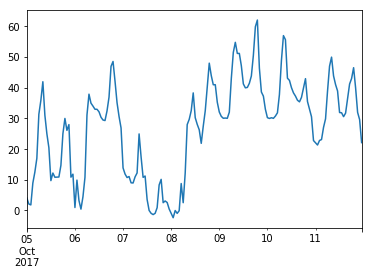

In [17]:
prices.plot()

Now we can do the same with the volumes. This time we need all odd rows, so the index has to start at 1. The datetime index for volumes and prices is the same, so that we can replace the volumes index with our previously created datetime index.

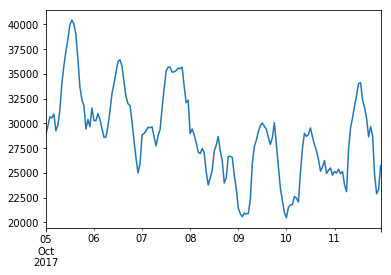

In [18]:
volumes = df[1::2].transpose().stack()
volumes.index = index
volumes.plot()

The above data is not stored as a DataFrame but as a *Series* which, in contrast to DataFrame, is one-dimensional. Since Series cannot be extended, we must first create a new empty DataFrame with our datetime index as its index. Then we append prices and volumes to the newsly created DataFrame and call *head()* to look at the first firve rows.

In [19]:
df = pd.concat([prices, volumes], axis=1)
df.columns = ["prices", "volumes"]
df.head()

,prices,volumes
2017-10-05 00:00:00,4.09,28873.0
2017-10-05 01:00:00,2.09,29697.5
2017-10-05 02:00:00,1.80,30656.5
2017-10-05 03:00:00,8.91,30551.9
2017-10-05 04:00:00,12.46,30941.4


Now that our data is in the right format and shape, we can begin with our exploratory analyses.

## Homework

Names: 
Milena Durdic
Dragana Saric
Paul Kneringer
Petar Petrov

### Exercise 1
Collect price and volume data from the entire year of 2017. Use pd.concat() to merge all dataframes together into a single one. A few hints:
- You need to loop over a number of dates which are one week apart. To create such a list use pandas *date_range* function and create dates in weekly frequency.
- Iteratively extend your DataFrame with the new data using Pandas concat function.
- If you run into errors when collecting an entire year and are unable to resolve these errors on your own, at least try to collect as many weeks as possible.

In [1]:
from bs4 import BeautifulSoup
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
start_date = pd.datetime(2017,4,9)
end_date = pd.datetime(2017,10,22) 

data_frame_2017 = pd.DataFrame(dtype=float)

dates = pd.date_range(start_date, end_date, freq='W')

for date in dates:
    url = urllib.request.urlopen('https://www.epexspot.com/en/market-data/dayaheadauction/auction-table/%s/de'%date)
    url = url.read()
    soup = BeautifulSoup(url,"lxml") 

    table = soup.find_all('table', class_='list hours responsive')

    df1 = pd.read_html(str(table[1]), header=0, encoding='utf8')[0]
    
    #modifying
    df1 = df1.drop(['Unnamed: 0', 'Unnamed: 1'], axis=1)
    
    prices = df1[::2].transpose().stack()
    volumes = df1[1::2].transpose().stack()
    
    index = pd.date_range(end='%s-23:00'%date, periods=7*24, freq='h')
    
    prices.index = index
    volumes.index = index
    
    df1 = pd.concat([prices, volumes], axis=1)
    
    df1.columns = ['Prices', 'Volumes']
    
    data_frame_2017 = pd.concat([data_frame_2017, df1], axis=0)
    
data_frame_2017.head(20)

,Prices,Volumes
2017-04-02 01:00:00-23:00,34.38,20432.3
2017-04-02 02:00:00-23:00,31.95,20702.3
2017-04-02 03:00:00-23:00,29.88,20574.1
2017-04-02 04:00:00-23:00,28.75,19403.0
2017-04-02 05:00:00-23:00,28.44,19043.9
2017-04-02 06:00:00-23:00,31.64,19653.6
2017-04-02 07:00:00-23:00,41.77,20675.9
2017-04-02 08:00:00-23:00,49.28,24019.5
2017-04-02 09:00:00-23:00,54.02,24100.1
2017-04-02 10:00:00-23:00,50.00,24896.6


### Exercise 2
Create a sample of peak prices (9:00 to 20:00) and base prices (24-hour mean) and summarize the data with a simple descriptive statistics containing min, max, mean, std deviation, as well as quantiles in steps of 0.1. Then create a histogram of the distribution of both figures in one plot.

Peak prices:

In [21]:
data_frame_peak = data_frame_2017[(data_frame_2017.index.hour >= 9) & (data_frame_2017.index.hour <= 20)]

In [22]:
data_frame_peak = data_frame_peak.drop(data_frame_peak.columns[1:], axis=1)
data_frame_peak.columns = ['Prices']

data_frame_peak = data_frame_peak.groupby(data_frame_peak.index.date)['Prices'].max()
print(data_frame_peak)


2017-04-02    54.02
2017-04-03    52.39
2017-04-04    48.10
2017-04-05    40.98
2017-04-06    41.57
2017-04-07    39.43
2017-04-08    38.24
2017-04-09    38.32
2017-04-10    43.50
2017-04-11    37.95
2017-04-12    40.00
2017-04-13    38.74
2017-04-14    20.10
2017-04-15    31.07
2017-04-16    32.15
2017-04-17    45.39
2017-04-18    48.38
2017-04-19    52.00
2017-04-20    42.61
2017-04-21    23.01
2017-04-22    30.63
2017-04-23    43.30
2017-04-24    43.00
2017-04-25    53.47
2017-04-26    45.93
2017-04-27    46.94
2017-04-28    34.93
2017-04-29     9.56
2017-04-30    25.78
2017-05-01    39.98
              ...  
2017-09-22    45.20
2017-09-23    46.94
2017-09-24    53.77
2017-09-25    55.20
2017-09-26    57.00
2017-09-27    49.78
2017-09-28    51.20
2017-09-29    48.25
2017-09-30    49.90
2017-10-01    36.04
2017-10-02    39.54
2017-10-03    55.93
2017-10-04    41.92
2017-10-05    48.52
2017-10-06    24.92
2017-10-07    47.97
2017-10-08    62.01
2017-10-09    56.94
2017-10-10    49.93


In [23]:
print("Summarized descriptive statistics for peak prices: ")
print('Minimum: ' + str(data_frame_peak.min()))
print('Maximum: ' + str(data_frame_peak.max()))
print('Standard deviation: ' + str(data_frame_peak.std()))
print('Mean: ' + str(data_frame_peak.mean()))

Summarized descriptive statistics for peak prices: 
Minimum: 9.56
Maximum: 83.02
Standard deviation: 8.958658478117806
Mean: 42.72517241379311


In [24]:
quantiles = data_frame_peak.quantile([0.25, 0.75])
print('Quantile 0.25: ' + str(quantiles.iloc[0]))
print('Quantile 0.75: ' + str(quantiles.iloc[1]))

Quantile 0.25: 37.975
Quantile 0.75: 47.89


In [25]:
data_frame_avg = data_frame_2017[(data_frame_2017.index.hour >= 0) & (data_frame_2017.index.hour <= 23)]

In [26]:
data_frame_avg = data_frame_avg.drop(data_frame_avg.columns[1:], axis=1)
data_frame_avg.columns = ['Prices']

data_frame_avg = data_frame_avg.groupby(data_frame_avg.index.date)['Prices'].mean()
print(data_frame_avg)

2017-04-02    37.993043
2017-04-03    38.565833
2017-04-04    33.231250
2017-04-05    29.665417
2017-04-06    33.408333
2017-04-07    34.430833
2017-04-08    28.850000
2017-04-09    27.376667
2017-04-10    33.255000
2017-04-11    27.981250
2017-04-12    28.856667
2017-04-13    30.127917
2017-04-14    15.758750
2017-04-15    17.681250
2017-04-16    25.276667
2017-04-17    34.297917
2017-04-18    36.898750
2017-04-19    37.390417
2017-04-20    28.758750
2017-04-21    11.573333
2017-04-22    10.757083
2017-04-23    30.755000
2017-04-24    36.411250
2017-04-25    39.942917
2017-04-26    36.809167
2017-04-27    36.908750
2017-04-28    30.258750
2017-04-29    -2.555000
2017-04-30   -27.690417
2017-05-01    28.185833
                ...    
2017-09-23    34.917083
2017-09-24    42.263333
2017-09-25    40.419583
2017-09-26    40.985833
2017-09-27    40.299167
2017-09-28    39.819583
2017-09-29    35.687917
2017-09-30    30.436667
2017-10-01    18.494583
2017-10-02    23.955000
2017-10-03    29

In [27]:
data_frame_peak_and_average = pd.DataFrame(columns = ['Peak Price', 'Average'])
data_frame_peak_and_average['Peak Price'] = data_frame_peak
data_frame_peak_and_average['Average'] = data_frame_avg
data_frame_peak_and_average.head() 


,Peak Price,Average
2017-04-02,54.02,37.993043
2017-04-03,52.39,38.565833
2017-04-04,48.10,33.231250
2017-04-05,40.98,29.665417
2017-04-06,41.57,33.408333


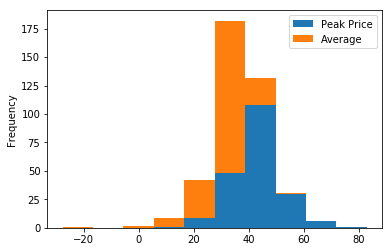

In [28]:
data_frame_peak_and_average.plot.hist(stacked=True)

### Exercise 3
Group the data by hour and plot the price distribution in one graph by horizontally stacking a number of box plots.

In [29]:
data_frame_new = data_frame_2017.drop(data_frame_2017.columns[1:], axis=1)
print(data_frame_new)
#data_frame_new = data_frame_new.groupby(data_frame_new.index.hour)
dff0 = data_frame_new.groupby(data_frame_new.index.hour)

                           Prices
2017-04-02 01:00:00-23:00   34.38
2017-04-02 02:00:00-23:00   31.95
2017-04-02 03:00:00-23:00   29.88
2017-04-02 04:00:00-23:00   28.75
2017-04-02 05:00:00-23:00   28.44
2017-04-02 06:00:00-23:00   31.64
2017-04-02 07:00:00-23:00   41.77
2017-04-02 08:00:00-23:00   49.28
2017-04-02 09:00:00-23:00   54.02
2017-04-02 10:00:00-23:00   50.00
2017-04-02 11:00:00-23:00   48.43
2017-04-02 12:00:00-23:00   44.95
2017-04-02 13:00:00-23:00   38.93
2017-04-02 14:00:00-23:00   36.68
2017-04-02 15:00:00-23:00   32.94
2017-04-02 16:00:00-23:00   30.91
2017-04-02 17:00:00-23:00   31.72
2017-04-02 18:00:00-23:00   32.19
2017-04-02 19:00:00-23:00   37.46
2017-04-02 20:00:00-23:00   41.78
2017-04-02 21:00:00-23:00   43.59
2017-04-02 22:00:00-23:00   38.97
2017-04-02 23:00:00-23:00   35.18
2017-04-03 00:00:00-23:00   31.08
2017-04-03 01:00:00-23:00   31.57
2017-04-03 02:00:00-23:00   30.13
2017-04-03 03:00:00-23:00   29.29
2017-04-03 04:00:00-23:00   29.47
2017-04-03 05:

In [30]:
for title, group in dff0:
    print(title)
    print(group.head())
    var = 'data{}'.format(title)
    locals()[var] = group

0
                           Prices
2017-04-03 00:00:00-23:00   31.08
2017-04-04 00:00:00-23:00   33.04
2017-04-05 00:00:00-23:00   20.00
2017-04-06 00:00:00-23:00   27.79
2017-04-07 00:00:00-23:00   37.93
1
                           Prices
2017-04-02 01:00:00-23:00   34.38
2017-04-03 01:00:00-23:00   31.57
2017-04-04 01:00:00-23:00   30.00
2017-04-05 01:00:00-23:00   12.48
2017-04-06 01:00:00-23:00   24.99
2
                           Prices
2017-04-02 02:00:00-23:00   31.95
2017-04-03 02:00:00-23:00   30.13
2017-04-04 02:00:00-23:00   29.64
2017-04-05 02:00:00-23:00    9.87
2017-04-06 02:00:00-23:00   23.02
3
                           Prices
2017-04-02 03:00:00-23:00   29.88
2017-04-03 03:00:00-23:00   29.29
2017-04-04 03:00:00-23:00   28.39
2017-04-05 03:00:00-23:00    9.04
2017-04-06 03:00:00-23:00   18.31
4
                           Prices
2017-04-02 04:00:00-23:00   28.75
2017-04-03 04:00:00-23:00   29.47
2017-04-04 04:00:00-23:00   27.94
2017-04-05 04:00:00-23:00   14.90
2017

In [31]:
print(data0)

                           Prices
2017-04-03 00:00:00-23:00   31.08
2017-04-04 00:00:00-23:00   33.04
2017-04-05 00:00:00-23:00   20.00
2017-04-06 00:00:00-23:00   27.79
2017-04-07 00:00:00-23:00   37.93
2017-04-08 00:00:00-23:00   39.02
2017-04-09 00:00:00-23:00   24.08
2017-04-10 00:00:00-23:00   24.02
2017-04-11 00:00:00-23:00   30.17
2017-04-12 00:00:00-23:00   23.05
2017-04-13 00:00:00-23:00   32.97
2017-04-14 00:00:00-23:00   36.95
2017-04-15 00:00:00-23:00    9.23
2017-04-16 00:00:00-23:00   30.46
2017-04-17 00:00:00-23:00   30.95
2017-04-18 00:00:00-23:00   31.07
2017-04-19 00:00:00-23:00   34.16
2017-04-20 00:00:00-23:00   29.22
2017-04-21 00:00:00-23:00    3.55
2017-04-22 00:00:00-23:00   20.20
2017-04-23 00:00:00-23:00   29.95
2017-04-24 00:00:00-23:00   38.55
2017-04-25 00:00:00-23:00   33.40
2017-04-26 00:00:00-23:00   32.58
2017-04-27 00:00:00-23:00   32.00
2017-04-28 00:00:00-23:00   31.08
2017-04-29 00:00:00-23:00   30.47
2017-04-30 00:00:00-23:00  -70.01
2017-05-01 00:

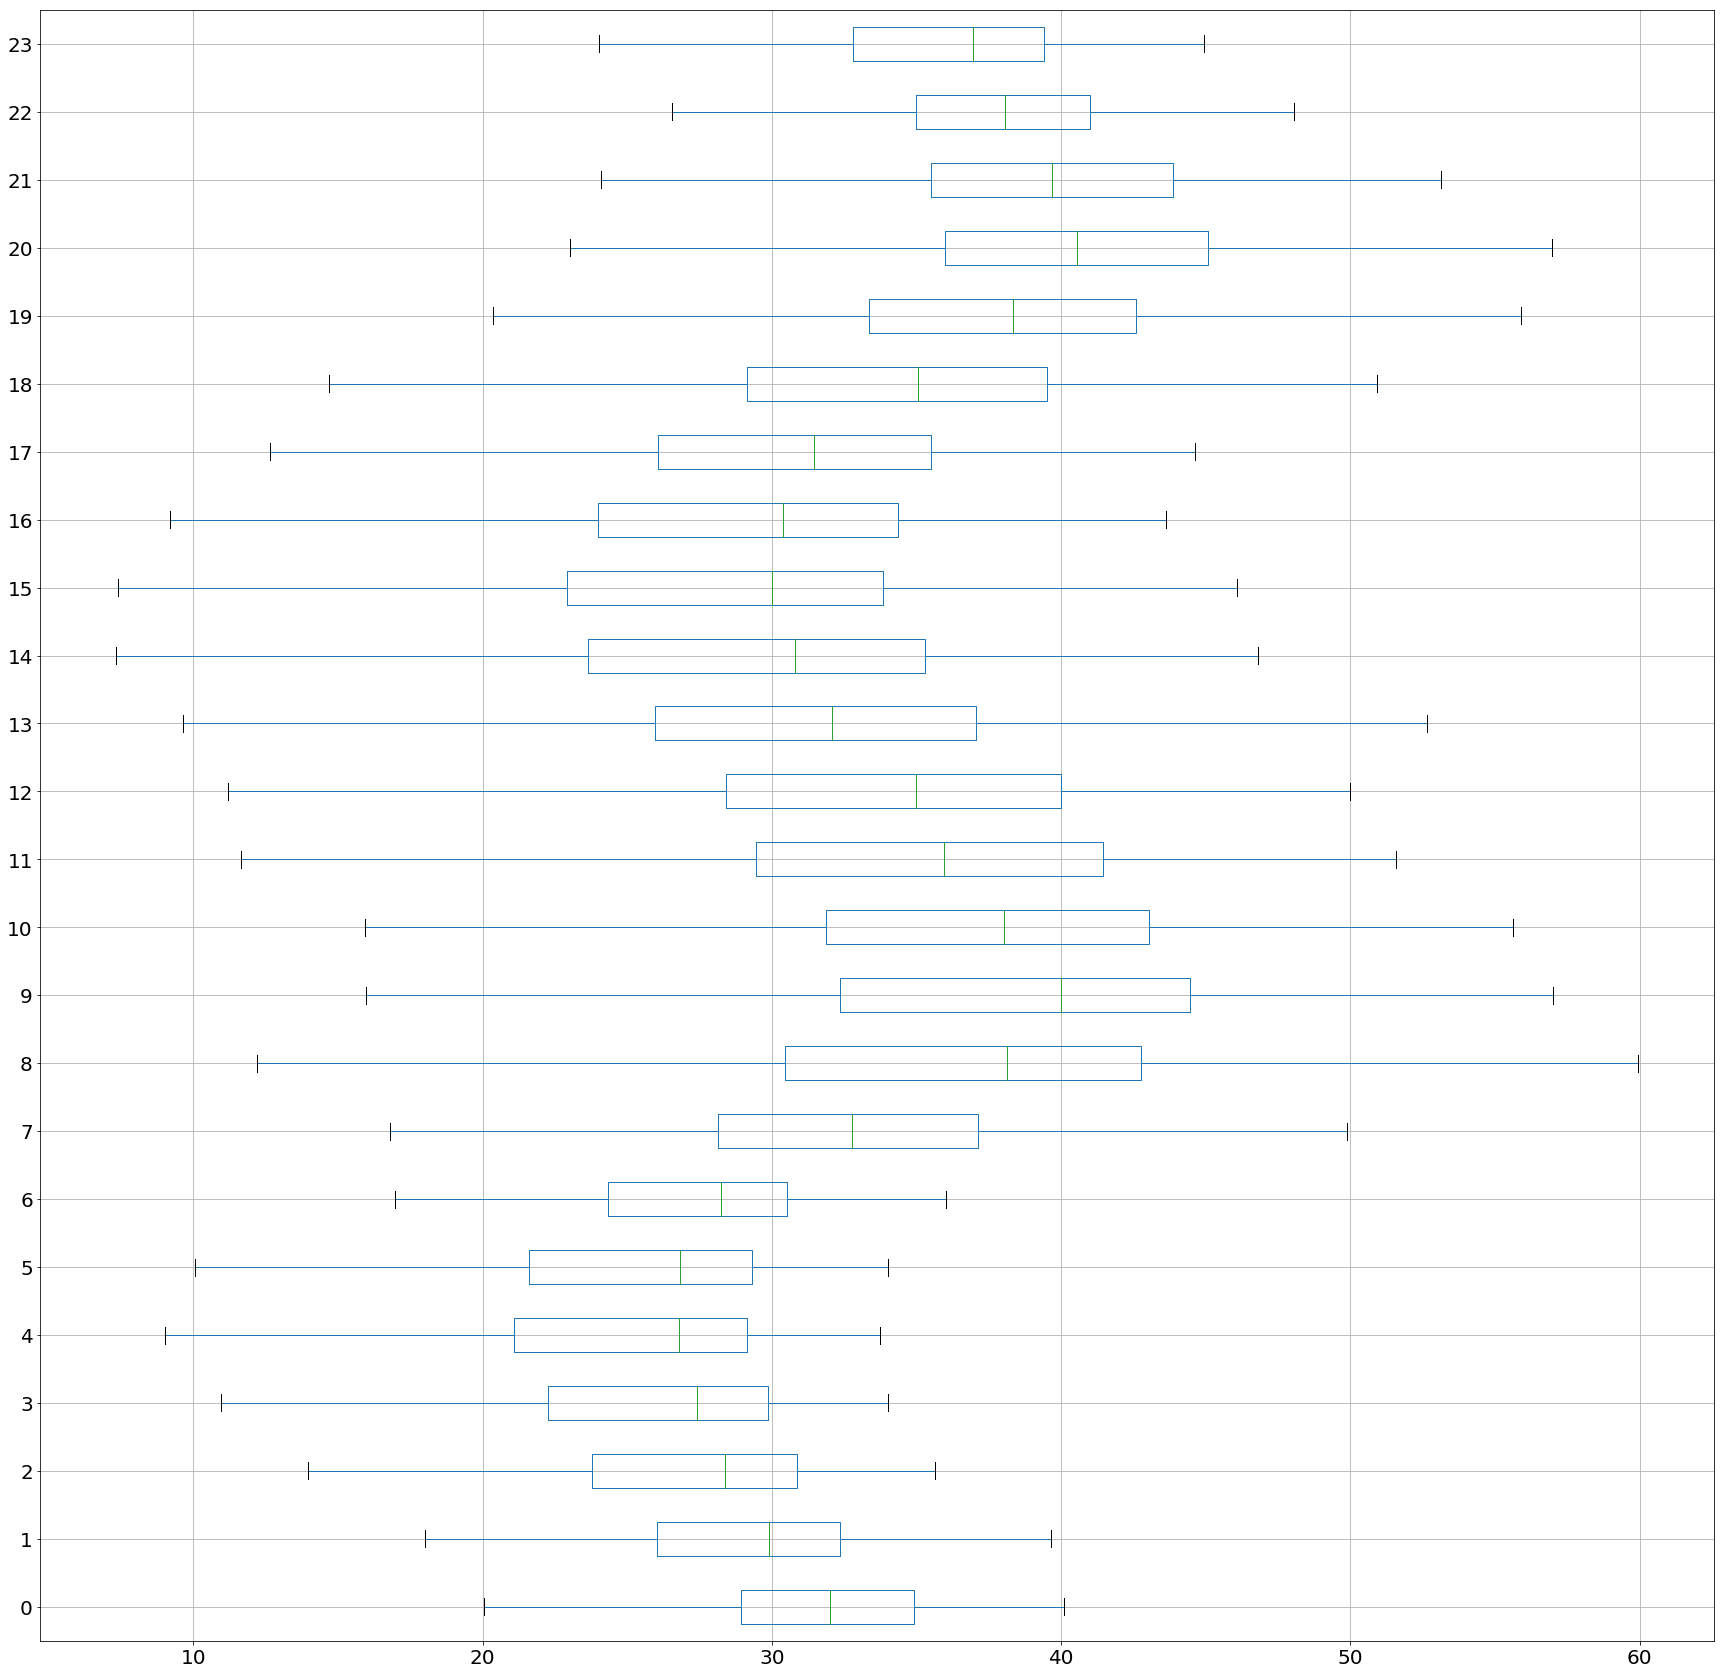

In [32]:
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')
hourly=pd.DataFrame(dtype=float)
hourly = pd.concat([data0,data1,data2,data3,data4,data5,data6,data7,data8,data9,data10,data11,data12,data13,data14,data15,data16,
                 data17,data18,data19,data20,data21,data22,data23],axis=1)
hourly.columns = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23']
hourly.boxplot(vert=False,showfliers=False,figsize=(30,30),fontsize=20)


### Exercise 4
Measure and plot the relationship between price and volume. What would be two numeric measures to describe the relationship? Briefly explain their differences. Hint:
- We discussed this in class when I drew on the flipchart.
- Do a little research on your own and explain the difference in your own words.

The two possible numeric measures to describe this relationship, as discussed in class, are Pearson ad Spearman correlations. Pearson product-moment correlation is useful because of its visual correlation with color range and it is good for future engineering. But if correlation between the two numeric measures have a specific order, like we had in the example from the class, Pearson correlation can show that there is no correlation even though that is not the proper outcome of our query. Pearson correlation coefficients measure only linear relationships. In that case we need another correlation type which takes the order into account and sorts before it looks at the correlation. That correlation type is Spearman correlation and it can tell us more about the data compared to the Pearson correlation type. However, computing both can be of certain value to us since we can then compare the two measures. Spearman correlation is computed on ranks and depicts monotonic relationships while Pearson correlation is computed on true values depicts linear relationships. So if, for example, Spearman correlation > Pearson correlation, that means that we have a correlation that is monotonic but not linear.

In [33]:
corr = data_frame_2017['Volumes'].corr(data_frame_2017['Prices'])
print("Corellation is " + str(corr))

Corellation is -0.302862123691


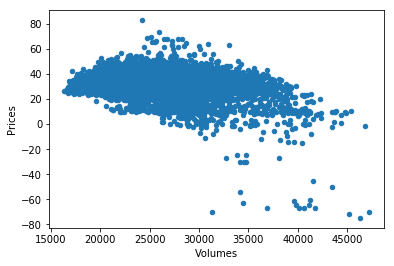

In [34]:
data_frame_2017.plot.scatter(x='Volumes', y='Prices')

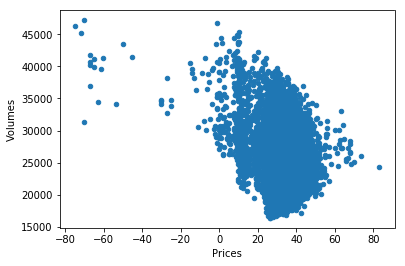

In [35]:
data_frame_2017.plot.scatter(x='Prices', y='Volumes')

### Exercise 5
Create a time series of daily averages and plot the result.

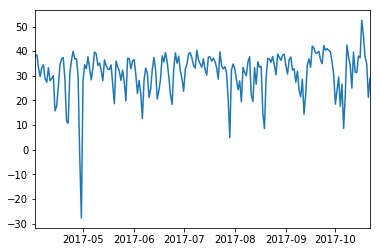

In [36]:
df = data_frame_2017['Prices'].groupby(data_frame_2017.index.date).mean()
df.plot()

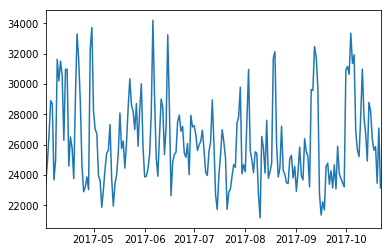

In [37]:
df1 = data_frame_2017['Volumes'].groupby(data_frame_2017.index.date).mean()
df1.plot()

### What you have learned

If you have gotton this far on your own, you have learned a great deal about getting things done in Python and Pandas. You now know a tool to collect data from the web, you have gotton a feel of Pandas indexing, aggregating and merging, and you have run some basic exploratory data analysis. Great job!